<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span><ul class="toc-item"><li><span><a href="#Загружаем-и-изучаем-данные" data-toc-modified-id="Загружаем-и-изучаем-данные-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Загружаем и изучаем данные</a></span><ul class="toc-item"><li><span><a href="#Вывод" data-toc-modified-id="Вывод-1.1.1"><span class="toc-item-num">1.1.1&nbsp;&nbsp;</span>Вывод</a></span></li></ul></li><li><span><a href="#Предобработка-данных" data-toc-modified-id="Предобработка-данных-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Предобработка данных</a></span><ul class="toc-item"><li><span><a href="#Предобработка-текста" data-toc-modified-id="Предобработка-текста-1.2.1"><span class="toc-item-num">1.2.1&nbsp;&nbsp;</span>Предобработка текста</a></span></li></ul></li><li><span><a href="#Вывод" data-toc-modified-id="Вывод-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Вывод</a></span></li></ul></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Обучение</a></span></li><li><span><a href="#Выводы" data-toc-modified-id="Выводы-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Выводы</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

# Проект для «Викишоп»

Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию. 

Обучите модель классифицировать комментарии на позитивные и негативные. В вашем распоряжении набор данных с разметкой о токсичности правок.

Постройте модель со значением метрики качества *F1* не меньше 0.75. 

**Инструкция по выполнению проекта**

1. Загрузите и подготовьте данные.
2. Обучите разные модели. 
3. Сделайте выводы.

Для выполнения проекта применять *BERT* необязательно, но вы можете попробовать.

**Описание данных**

Данные находятся в файле `toxic_comments.csv`. Столбец *text* в нём содержит текст комментария, а *toxic* — целевой признак.

## Подготовка

Инсталируем библиотеки для работы с текстом и графикой

In [1]:
!pip install nltk
!pip install wordcloud

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
     |████████████████████████████████| 366 kB 2.0 MB/s eta 0:00:01
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.


### Загружаем и изучаем данные

In [2]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
#%matplotlib inline

import re
from wordcloud import WordCloud, STOPWORDS

import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords as nltk_stopwords
from sklearn.feature_extraction.text import TfidfVectorizer# < напишите код здесь >

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import lightgbm as lgbm
from lightgbm import LGBMClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score

from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score

from sklearn.metrics import confusion_matrix

#from nltk.corpus import stopwords
nltk.download('stopwords')
stop_words = set(nltk_stopwords.words('english')) 

[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [3]:
data_train = pd.read_csv('/datasets/toxic_comments.csv')

Сделаем копию исходного датасета

In [4]:
batch_1 = data_train.copy()

In [5]:
batch_1.head()

,text,toxic
0,Explanation\nWhy the edits made under my usern...,0
1,D'aww! He matches this background colour I'm s...,0
2,"Hey man, I'm really not trying to edit war. It...",0
3,"""\nMore\nI can't make any real suggestions on ...",0
4,"You, sir, are my hero. Any chance you remember...",0


In [6]:
batch_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159571 entries, 0 to 159570
Data columns (total 2 columns):
text     159571 non-null object
toxic    159571 non-null int64
dtypes: int64(1), object(1)
memory usage: 2.4+ MB


In [7]:
batch_1.duplicated().sum()

0

In [8]:
batch_1.describe(include=[np.object])

,text
count,159571
unique,159571
top,"It is you, who is arguing in a neo-ricardian f..."
freq,1


In [9]:
batch_1['toxic'].value_counts()

0    143346
1     16225
Name: toxic, dtype: int64

#### Вывод

В  датасете 159571  строк и 2 столбца:
* text
* toxic - целевой признак

Типы данных столбцов: int64(1), object(1). Память занимает 2.4+ MB. Пропуски и дубликаты отсутствуют.
Частота, с которой повторяются фразы - 1. Все строки в text - уникальны.

Текст необходимо очистить.

Классы несбалансированны.

### Предобработка данных

Приведем данные к типу unicode

In [10]:
batch_1['text']=batch_1['text'].astype('U').values

Преобразуем в однобайтное представление целого числа, тем самых уменьшим объем занимаемой памяти

In [11]:
batch_1['toxic']=batch_1['toxic'].astype('int8')

Проверим уменьшилась ли память

In [12]:
batch_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159571 entries, 0 to 159570
Data columns (total 2 columns):
text     159571 non-null object
toxic    159571 non-null int8
dtypes: int8(1), object(1)
memory usage: 1.4+ MB


Визуализируем дисбаланс классов и посчитаем численное значение

Text(0.5, 1.0, 'Соотношение положительных и отрицательных отзывов')

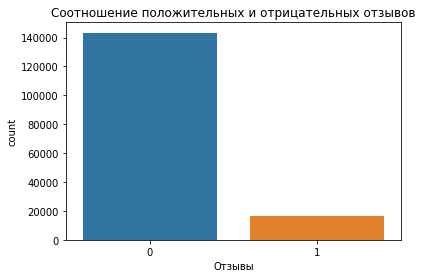

In [13]:
sns.countplot(batch_1.toxic)
plt.xlabel('Отзывы')
plt.title('Соотношение положительных и отрицательных отзывов')

In [14]:
class_part= batch_1['toxic'].value_counts()[0] / batch_1['toxic'].value_counts()[1]
print ('Соотношение дисбаланса классов равно:', class_part)

Соотношение дисбаланса классов равно: 8.834884437596301


#### Предобработка текста
* Переведем все буквы в тексте в нижний регистр;
* Удалим пунктуацию, пробельные символы и цифры (чиселы) с  использованием  регулярных выражений;
* Проведем лемматизацию;
* Удалим стоп слова и векторизируем текст с помощью TFIDF.

In [15]:
lemmatizer = nltk.WordNetLemmatizer()

In [16]:
def preprocess_text(text):
    stop_lower = text.lower()    
    clean_punct = re.sub(r"(?:\n|\r)", " ", stop_lower)
    clean_word = [re.sub(r"[^a-zA-Z ]+", "", clean_punct).strip()]
    clean_text = " ".join([lemmatizer.lemmatize(word) for word in clean_word])
    return clean_text

In [17]:
batch_1['text_clean']=batch_1['text'].apply(lambda x: preprocess_text(x))

In [18]:
batch_1.head()

,text,toxic,text_clean
0,Explanation\nWhy the edits made under my usern...,0,explanation why the edits made under my userna...
1,D'aww! He matches this background colour I'm s...,0,daww he matches this background colour im seem...
2,"Hey man, I'm really not trying to edit war. It...",0,hey man im really not trying to edit war its j...
3,"""\nMore\nI can't make any real suggestions on ...",0,more i cant make any real suggestions on impro...
4,"You, sir, are my hero. Any chance you remember...",0,you sir are my hero any chance you remember wh...


Визуализируем положительные и отрицательные отзывы

Text(0.5, 1.0, 'Положительные комментарии')

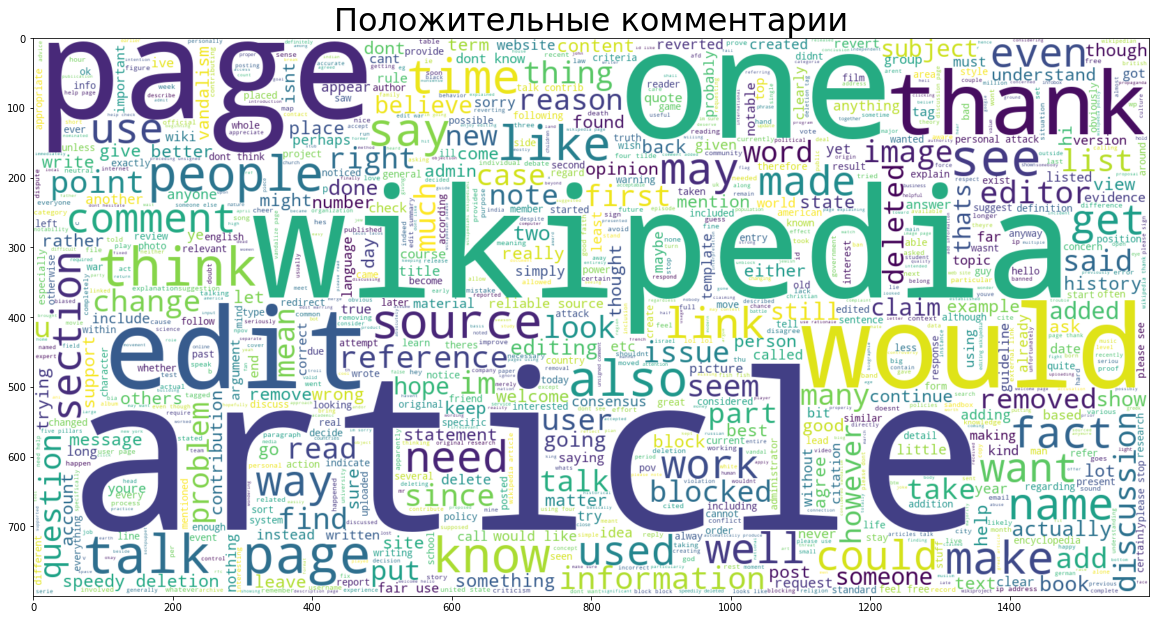

In [19]:
plt.figure(figsize = (20,20)) 
wc = WordCloud(background_color='white', max_words = 1000 , width = 1600 , height = 800, stopwords = stop_words).generate(" ".join(batch_1.query('toxic == 0')['text_clean']))
plt.imshow(wc , interpolation = 'bilinear')
plt.title('Положительные комментарии', fontsize=32)

Text(0.5, 1.0, 'Отрицательные комментарии')

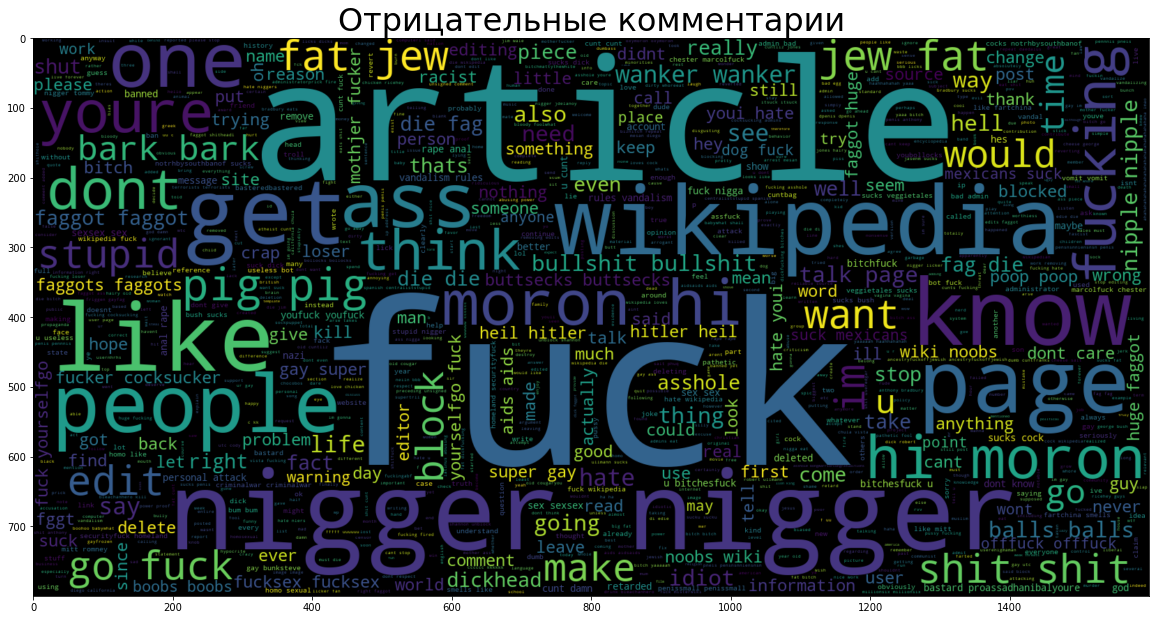

In [20]:
plt.figure(figsize = (20,20)) 
wc = WordCloud(max_words = 1000 , width = 1600 , height = 800, stopwords = stop_words).generate(" ".join(batch_1.query('toxic == 1')['text_clean']))
plt.imshow(wc , interpolation = 'bilinear')
plt.title( 'Отрицательные комментарии', fontsize=32)

Словарь негативных слов из облака слов

In [21]:
toxic_words = wc.words_.keys()
toxic_words_list = list(toxic_words)

Выбираем первые 100 "плохих" слов

In [22]:
toxic_words_top100 = toxic_words_list[:100]

Проверяем какие слова находящиеся в строке относятся к первым 100 негативным и оставляем их

In [23]:
def clean_negwords(text):
    clean_text = [w for w in text.split() if  w in toxic_words_top100]
    return " ".join(clean_text)

batch_1['negwords_all'] = batch_1['text_clean'].apply(lambda x: clean_negwords(x))
batch_1.head(10)

,text,toxic,text_clean,negwords_all
0,Explanation\nWhy the edits made under my usern...,0,explanation why the edits made under my userna...,please dont talk page im
1,D'aww! He matches this background colour I'm s...,0,daww he matches this background colour im seem...,im talk
2,"Hey man, I'm really not trying to edit war. It...",0,hey man im really not trying to edit war its j...,im really edit guy talk page
3,"""\nMore\nI can't make any real suggestions on ...",0,more i cant make any real suggestions on impro...,make think need want please let know
4,"You, sir, are my hero. Any chance you remember...",0,you sir are my hero any chance you remember wh...,page thats
5,"""\n\nCongratulations from me as well, use the ...",0,congratulations from me as well use the tools ...,well use well talk
6,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1,cocksucker before you piss around on my work,
7,Your vandalism to the Matt Shirvington article...,0,your vandalism to the matt shirvington article...,article please dont
8,Sorry if the word 'nonsense' was offensive to ...,0,sorry if the word nonsense was offensive to yo...,im would im one use page article someone
9,alignment on this subject and which are contra...,0,alignment on this subject and which are contra...,


### Вывод

1. Перевели данные к типу unicode;
2. 42% сократили объем занимаемой памяти;
3. Очистили текст: понизили регистр во всех словах, удалили знаки пунктуации и числа, провели лемматизацию.
4. Визуализировали положительные и отрицательные комментарии.

## Обучение

Разделим выборку на обучающую, валидационную и тестовую, в соотношении 70:30. Для этого Случайное перемешиваем случайным образом строки (shuffle) и равномерно распределим количество классов в наборах данных (stratify).

In [24]:
features = batch_1.drop(['toxic', 'text', 'negwords_all'], axis=1)
target = batch_1.toxic

In [25]:
X_train, X_test, y_train, y_test = train_test_split(features, 
                                                                              target,
                                                                              shuffle=True,
                                                                              stratify=target,
                                                                              test_size=0.3)

In [26]:
print("Размер обучающей выборки:", X_train.shape)

print("Размер тестирующей выборки", X_test.shape)

Размер обучающей выборки: (111699, 1)
Размер тестирующей выборки (47872, 1)


In [27]:
print(f"Количество строк в y_train по классам: {np.bincount(y_train)}")

print(f"Количество строк в y_test по классам: {np.bincount(y_test)}")

Количество строк в y_train по классам: [100342  11357]
Количество строк в y_test по классам: [43004  4868]


Создадим мешок слов, учитывая частоту употребления слов TF-IDF, удалив стоп-слова.

In [28]:
count_tf_idf = TfidfVectorizer(stop_words=stop_words)

In [29]:
X_train = count_tf_idf.fit_transform(X_train['text_clean'])

In [30]:
X_test = count_tf_idf.transform(X_test['text_clean'])

Подберем гиперпараметры для следующих моделей:
* LogisticRegression - логарифмическая регрессия
* RandomForestClassifier - случайный лес для регрессии
* LGBMClassifier - градиентный бустинг и модель линейной регрессии

Оценим точность предсказания по метрике f1.
Наши данные несбалансированные, поэтому используем аргумент class_weight придадим ему значение balanced (англ. «сбалансированный»), алгоритм посчитает, во сколько раз класс «0» встречается чаще класса «1». Бóльший вес будет у редкого класса.

In [31]:
models = {
    'LogisticRegression': LogisticRegression(),
     'RandomForestClassifier': RandomForestClassifier(),
    'LGBMClassifier': LGBMClassifier()   
}


params = {
    'LogisticRegression':{
          'class_weight':['balanced'],
          'solver':['newton-cg', 'lbfgs', 'liblinear'],
          'C':[1,10]
    },        

     'RandomForestClassifier':{
            'criterion': ['gini', 'entropy'],
            'min_samples_split' : [2],
            'n_estimators' : [10, 100],
            'min_samples_leaf' : [2],
            'class_weight' : ['balanced']
    },
    
    'LGBMClassifier': {
        'num_iterations':[300],
        'feature_fraction':[0.64,0.8],
        'bagging_fraction':[0.8,0.9],
        'class_weight':['balanced']       
        }  
}

Функция для подсчета гиперпараметров для выбранных моделей

In [32]:
def fit(train_features, train_target):
        """
        В соответствии со списком моделей и выбранными параметрами 
        на обучающей выборке, GridSearchCV подбирает оптимальные гиперпараметры 
        используя кросс-валидаюцию с наивысшими показателями метрики f1
      
        """

        for name in models.keys():
            est = models[name]
            est_params = params[name]
            gscv = GridSearchCV(estimator=est, param_grid=est_params, scoring='f1', cv=3, n_jobs=-1)
            gscv.fit(train_features, train_target)
            print("best parameters are: {}".format(gscv.best_estimator_))

In [33]:
fit(X_train, y_train) #общее время расчета занимает больше двух часов

best parameters are: LogisticRegression(C=10, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='newton-cg', tol=0.0001, verbose=0,
                   warm_start=False)
best parameters are: RandomForestClassifier(bootstrap=True, class_weight='balanced',
                       criterion='entropy', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=2,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=None, verbose=0, warm_start=False)
best parameters are: LGBMClassifier(bagging_fraction=0.8, boosting_type='gbdt',
               class_weight='balanced', col

Напишем функцию, которая будем рассчитывать метрику 

In [34]:
def f1_scorer(model, feat_tr, targ_tr, feat_test, tr_test):
   
    model_study = model
    model_study.fit(feat_tr, targ_tr)

    predicted = model_study.predict(feat_test) 
    f1 = f1_score(tr_test, predicted)
    return predicted, f1

In [35]:
predicted_LR, f1_LR_test = f1_scorer(LogisticRegression(C=10, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False), X_train, y_train, X_test, y_test)

In [36]:
predicted_RFC, f1_RFC_test = f1_scorer(RandomForestClassifier(bootstrap=True, class_weight='balanced',
                       criterion='entropy', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=2,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=None, verbose=0, warm_start=False),   X_train, y_train, X_test, y_test)

In [37]:
predicted_LGBMR, f1_LGBMR_test = f1_scorer(LGBMClassifier(bagging_fraction=0.8, boosting_type='gbdt',
               class_weight='balanced', colsample_bytree=1.0,
               feature_fraction=0.8, importance_type='split', learning_rate=0.1,
               max_depth=-1, min_child_samples=20, min_child_weight=0.001,
               min_split_gain=0.0, n_estimators=100, n_jobs=-1,
               num_iterations=300, num_leaves=31, objective=None,
               random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0), X_train, y_train, X_test, y_test)

Необходимый порог f1 не меньше 0,75 преодолела модель LogisticRegression. Проверим сохранится ли результат на тестовых выборках.

In [38]:
model_test = pd.DataFrame({'Модель': ['LogisticRegression','RandomForestClassifier','LGBMClassifier'],
                'f1_test': [f1_LR_test, f1_RFC_test, f1_LGBMR_test]})
model_test

,Модель,f1_test
0,LogisticRegression,0.769885
1,RandomForestClassifier,0.700584
2,LGBMClassifier,0.743900


Визуализируем результаты прогнозирования классификации лучшей модели LogisticRegression построив матрицу путаницы.

Text(0.5, 1, 'Матрица путаницы')

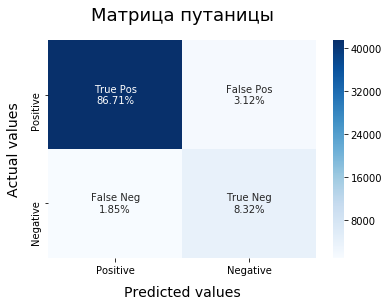

In [39]:
cf_matrix = confusion_matrix(y_test, predicted_LR)
categories  = ['Positive','Negative']
group_names = ['True Pos', 'False Pos', 'False Neg', 'True Neg']

group_percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten() / np.sum(cf_matrix)]

labels = [f'{v1}\n{v2}' for v1, v2 in zip(group_names,group_percentages)]
labels = np.asarray(labels).reshape(2,2)

sns.heatmap(cf_matrix, annot = labels, cmap = 'Blues',fmt = '',
                xticklabels = categories, yticklabels = categories)

plt.xlabel("Predicted values", fontdict = {'size':14}, labelpad = 10)
plt.ylabel("Actual values"   , fontdict = {'size':14}, labelpad = 10)
plt.title ("Матрица путаницы", fontdict = {'size':18}, pad = 20)

Для модели LogisticRegression построим кривую ROC-AUC.
Кривая ROC — это отношение TPR (True Positive Rate) к FPR ( False Positive Rate), которая иллюстрирует работу системы двоичного классификатора. Площадь под кривой показывает качество алгоритма (больше — лучше), важной характеристикой является крутизна самой кривой в идеале кривая должна стремиться к точке (0,1).

In [40]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc


model_test= LogisticRegression(C=10, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)
model_test.fit(X_train, y_train)# обучаем модель

probabilities_test = model_test.predict_proba(X_test)
roc_auc_test = roc_auc_score(y_test, probabilities_test[:,1])

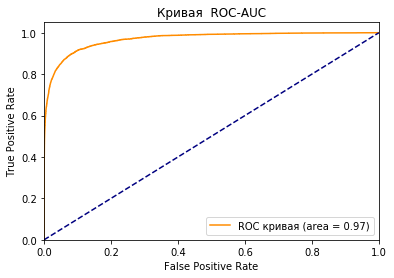

In [41]:
fpr, tpr, treshold = roc_curve(y_test, probabilities_test[:,1])# рассчитываем roc-кривую
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, color='darkorange',
         label='ROC кривая (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Кривая  ROC-AUC')
plt.legend(loc="lower right")
plt.show()


 В нашем случае площадь под кривой равна 0,97 >0,5 (при значениях 0,5 - случайный классификатор, пунктирная линия на графике), следовательно наша модель - отличный классификатор.

## Выводы

В работе была подобрана модель для определения токсичности комментарий с метрикой качества F1 не меньше 0.75.
После тестирования на тестовых выборках были получены следующие результаты: 

| Модель        | F1          |  
|:------------------:|:----------------------------------:|
| LogisticRegression            |  0.766128 | 
| RandomForestClassifier  |  0.709658   |  
| LGBMClassifier  |   0.743274   |     


Для выполнения поставленной задачи были проделаны следующие этапы:
* загружен и изучен датасет;
* проведена замена типа данных;
* произведена предобработка, которая включила в себя: понижение регистра, удаление знаков пунктуации и чисел, леммотизацию слов;
* визуализирован результат;
* проведено разбиение данных на обучающую, валидационную и тестовую выборку;
* создан мешок слов, при этом учитена частота употребления слов TF-IDF и  удалины стоп-слова.
* выявленный дисбаланс классов компенсирован при построение модели аргументом - class_weight='balanced';
* подобраны гиперпараметры спомощью GridSearchCV для рассматриваемых моделей: LogisticRegression, RandomForestClassifier, LGBMClassifier.
* построена матрица путаницы для наилучшей модели LogisticRegression.

Наилучшей моделью с метрикой качества F1 определена модель LogisticRegression.

## Чек-лист проверки

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Данные загружены и подготовлены
- [x]  Модели обучены
- [x]  Значение метрики *F1* не меньше 0.75
- [x]  Выводы написаны